In [74]:
# Core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Plot style
sns.set(style="whitegrid")


In [75]:
# Create data folder
os.makedirs("data", exist_ok=True)
local_path = "data/winequality-red.csv"

# Download CSV if it doesn't exist
if not os.path.isfile(local_path):
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    df = pd.read_csv(url, sep=";")
    df.to_csv(local_path, index=False)
    print(f"Downloaded and saved to {local_path}")
else:
    df = pd.read_csv(local_path, sep=";", engine="python")
    print(f"Loaded existing file at {local_path}")

# Strip any whitespace from column names
df.columns = df.columns.str.strip()

# Check if CSV loaded properly (should have 12 columns)
if len(df.columns) == 1:
    print("CSV loaded as single column. Fixing now...")
    df = df.iloc[:,0].str.split(",", expand=True)
    df.columns = [
        'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
        'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
        'pH', 'sulphates', 'alcohol', 'quality'
    ]

# Convert all columns to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check data
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
df.head()


Loaded existing file at data/winequality-red.csv
CSV loaded as single column. Fixing now...
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Shape: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [76]:
print("Missing values:\n", df.isnull().sum())


Missing values:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


/var/folders/0t/0vhy93bx667202bw699ppxfc0000gn/T/ipykernel_22668/3362763927.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="quality", data=df, palette="mako")


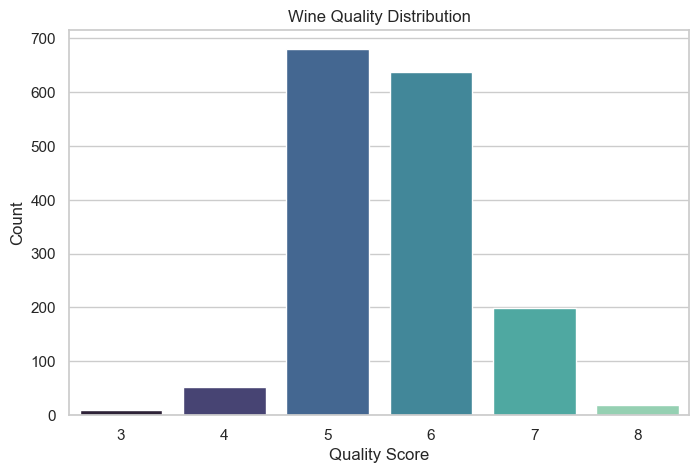

In [77]:
plt.figure(figsize=(8,5))
sns.countplot(x="quality", data=df, palette="mako")
plt.title("Wine Quality Distribution")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.show()


In [78]:
# Features and target
X = df.drop("quality", axis=1)
y = df["quality"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Bin quality into Low/Medium/High
def quality_bin(q):
    if q <= 5:
        return "Low"
    elif q == 6:
        return "Medium"
    else:
        return "High"

y_train_binned = y_train.map(quality_bin)
y_test_binned = y_test.map(quality_bin)

print("Binned class distribution (train):\n", y_train_binned.value_counts())
print("\nBinned class distribution (test):\n", y_test_binned.value_counts())


Binned class distribution (train):
 quality
Low       595
Medium    510
High      174
Name: count, dtype: int64

Binned class distribution (test):
 quality
Low       149
Medium    128
High       43
Name: count, dtype: int64


In [79]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_binned)
y_test_enc = le.transform(y_test_binned)
print("Label mapping:", dict(zip(le.classes_, range(len(le.classes_)))))


Label mapping: {'High': 0, 'Low': 1, 'Medium': 2}


In [80]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train_binned)

y_pred_lr_bin = lr.predict(X_test)

print("=== Logistic Regression (Binned) ===")
print(classification_report(y_test_binned, y_pred_lr_bin, zero_division=0))


=== Logistic Regression (Binned) ===
              precision    recall  f1-score   support

        High       0.84      0.37      0.52        43
         Low       0.68      0.77      0.72       149
      Medium       0.56      0.59      0.57       128

    accuracy                           0.64       320
   macro avg       0.69      0.57      0.60       320
weighted avg       0.65      0.64      0.63       320



In [81]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train_binned)

y_pred_rf_bin = rf.predict(X_test)

print("=== Random Forest (Binned) ===")
print(classification_report(y_test_binned, y_pred_rf_bin, zero_division=0))


=== Random Forest (Binned) ===
              precision    recall  f1-score   support

        High       0.75      0.56      0.64        43
         Low       0.77      0.75      0.76       149
      Medium       0.63      0.70      0.66       128

    accuracy                           0.70       320
   macro avg       0.71      0.67      0.69       320
weighted avg       0.71      0.70      0.70       320



In [82]:
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train_enc)

y_pred_xgb_enc = xgb.predict(X_test)
y_pred_xgb_bin = le.inverse_transform(y_pred_xgb_enc)

print("=== XGBoost (Binned, Encoded Labels) ===")
print(classification_report(y_test_binned, y_pred_xgb_bin, zero_division=0))


=== XGBoost (Binned, Encoded Labels) ===
              precision    recall  f1-score   support

        High       0.68      0.65      0.67        43
         Low       0.77      0.77      0.77       149
      Medium       0.65      0.66      0.65       128

    accuracy                           0.71       320
   macro avg       0.70      0.69      0.70       320
weighted avg       0.71      0.71      0.71       320



In [83]:
models = {
    "Logistic Regression": y_pred_lr_bin,
    "Random Forest": y_pred_rf_bin,
    "XGBoost": y_pred_xgb_bin
}

for name, preds in models.items():
    print(f"{name} Accuracy: {accuracy_score(y_test_binned, preds):.4f}")


Logistic Regression Accuracy: 0.6406
Random Forest Accuracy: 0.7031
XGBoost Accuracy: 0.7094


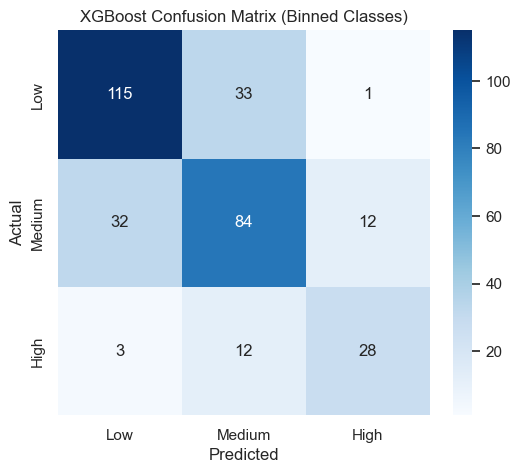

In [84]:
cm = confusion_matrix(y_test_binned, y_pred_xgb_bin, labels=["Low","Medium","High"])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low","Medium","High"],
            yticklabels=["Low","Medium","High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix (Binned Classes)")
plt.show()


/var/folders/0t/0vhy93bx667202bw699ppxfc0000gn/T/ipykernel_22668/2126409226.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette="viridis")


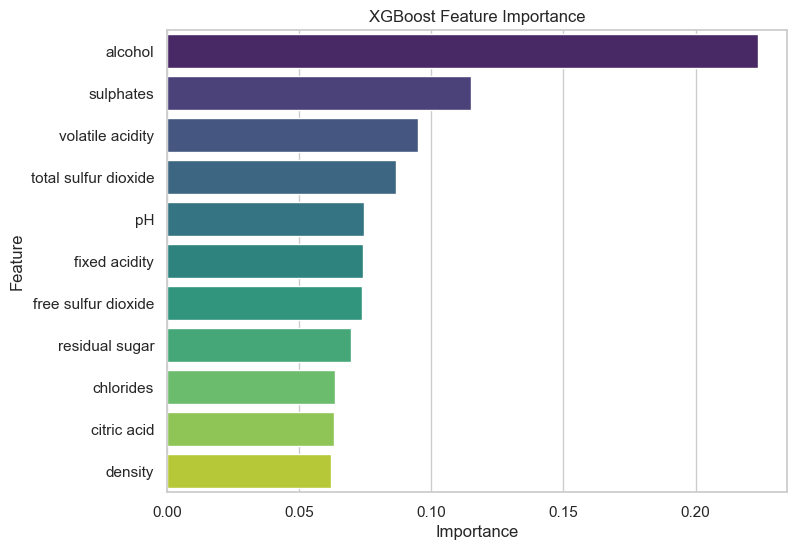

In [85]:
importances = xgb.feature_importances_
features = X.columns

feat_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette="viridis")
plt.title("XGBoost Feature Importance")
plt.show()
